# This model: build a simple transformer and train it

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
config_default = {
    'n_layer':4,
    'n_model':128,
    'n_ff':256,
    'n_head':8,
    'head_size':16, # fix head_size * n_head = n_model; also needs to be even for RoPE
    'n_context':256,
    'n_token':66, # come from data
    'RoPE':True, # fix this at Ture because other embeddings have not been impplemented yet
    'dropout':0.1,
}

In [5]:
SANITY_CHECK = True

# Model

In [6]:
class Head(nn.Module):
    """
    standard attenstion head (position embedding done before head)
    """
    def __init__(self, config=config_default):
        super().__init__()
        self.n_model = config['n_model']
        self.n_head = config['n_head']
        self.head_size = config['head_size']
        self.n_context = config['n_context']
        self.K = nn.Linear(self.n_model, self.head_size ,bias=False)
        self.Q = nn.Linear(self.n_model, self.head_size ,bias=False)
        self.V = nn.Linear(self.n_model, self.head_size ,bias=False)
        self.register_buffer('mask', 
          torch.triu(torch.full((self.n_context,self.n_context), float('-inf')), diagonal=1))
          # used for masking attention weights
    def forward(self, x):
        # x: (..., n_context, n_model)
        k = self.K(x) #  (..., n_context, head_size)
        q = self.K(x)
        v = self.K(x)
        w = torch.einsum('...ik, ...jk -> ...ij', k, q) * self.head_size**-0.5 # (..., n_context, n_context)
        # mask upper half with -inf (will become zero in softmax)
        w = w+self.mask
        w = F.softmax(w, dim=-1)
        out = torch.einsum('...ij, ...jk -> ...ik', w, v) #  (..., n_context, head_size)
        return out

In [7]:
if SANITY_CHECK:
    H = Head()
    x = torch.ones((8,256,128))
    o = H(x)
    print(o.shape)
    print(H.mask[:5,:5])

torch.Size([8, 256, 16])
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


In [8]:
class RoPEHead(nn.Module):
    """
    attention head using RoPE position embedding
    """
    # I need to turn k and q by some theta value that depends on the location in the context.
    # so this matrix can totally be precomputed... it's just a head_size * head_size thing.
    # or I could even say that I make a (head_size/2,2,2) tensor and reshape k, q to perform the rotation.
    def __init__(self, config=config_default):
        super().__init__()
        self.n_model = config['n_model']
        self.n_head = config['n_head']
        self.head_size = config['head_size']
        self.n_context = config['n_context']
        self.K = nn.Linear(self.n_model, self.head_size ,bias=False)
        self.Q = nn.Linear(self.n_model, self.head_size ,bias=False)
        self.V = nn.Linear(self.n_model, self.head_size ,bias=False)
        self.register_buffer('mask', 
          torch.triu(torch.full((self.n_context,self.n_context), float('-inf')), diagonal=1))
          # used for masking attention weights
        rotation_matrix = torch.zeros((self.head_size//2, 2, 2))
        exponents = torch.arange(self.head_size//2)/(self.head_size//2)
        thetas = 10000**(-exponents)
        self.register_buffer('cos', torch.cos(thetas))
        self.register_buffer('sin', torch.sin(thetas))
    def forward(self, x):
        # x: (..., n_context, n_model)
        k = self.K(x) #  (..., n_context, head_size)
        q = self.K(x)
        v = self.K(x)
        
        # rotate: spliting the tensor is faster than matrix multiplication
        k1 = k[...,::2]
        k2 = k[...,1::2]
        k[...,::2] = k1*self.cos + k2*self.sin
        k[...,1::2] = -k1*self.sin + k2*self.cos
        q1 = q[...,::2]
        q2 = q[...,1::2]
        q[...,::2] = q1*self.cos + q2*self.sin
        q[...,1::2] = -q1*self.sin + q2*self.cos
        
        w = torch.einsum('...ik, ...jk -> ...ij', k, q) * self.head_size**-0.5 # (..., n_context, n_context)
        # mask upper half with -inf (will become zero in softmax)
        w = w+self.mask
        w = F.softmax(w, dim=-1)
        out = torch.einsum('...ij, ...jk -> ...ik', w, v) #  (..., n_context, head_size)
        return out

In [9]:
if SANITY_CHECK:
    H = RoPEHead()
    x = torch.ones((2,256,128))
    o = H(x)
    print(o.shape)

torch.Size([2, 256, 16])


In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, config=config_default):
        super().__init__()
        self.n_head = config['n_head']
        if config['RoPE']:
            self.heads = nn.ModuleList([RoPEHead(config) for i in range(self.n_head)])
        else:
            self.heads = nn.ModuleList([Head(config) for i in range(self.n_head)])
        self.linear = nn.Linear(self.n_head*config['head_size'], config['n_model'])
        self.dropout = nn.Dropout(config['dropout'])
    def forward(self, x):
        outs = [h(x) for h in self.heads]
        out = torch.cat(outs, dim=-1)
        return self.dropout(self.linear(out))

In [11]:
if SANITY_CHECK:
    MH = MultiHeadAttention()
    x = torch.ones((8,256,128))
    o = MH(x)
    print(o.shape)

torch.Size([8, 256, 128])


In [12]:
class FeedForward(nn.Module):
    """
    standard GELU feed forward
    use no bias (preferred by recent models)
    """
    def __init__(self, config=config_default):
        super().__init__()
        n_model, n_ff = config['n_model'], config['n_ff']
        self.FF = nn.Sequential(
            nn.Linear(n_model, n_ff, bias=False),
            nn.GELU(),
            nn.Linear(n_ff, n_model, bias=False),
            nn.Dropout(config['dropout'])
        )
    def forward(self, x):
        return self.FF(x)

In [13]:
if SANITY_CHECK:
    FF = FeedForward()
    x = torch.ones((8,256,128))
    o = FF(x)
    print(o.shape)

torch.Size([8, 256, 128])


In [14]:
class TransformerLayer(nn.Module):
    """
    one layer in the transformer
    """
    def __init__(self, config=config_default):
        super().__init__()
        self.MHA = MultiHeadAttention(config)
        self.FF = FeedForward(config)
        n_model = config['n_model']
        self.MHA_norm = nn.LayerNorm(n_model) # wanted to use MSE but it's not on the pytorch version in my env...
        self.FF_norm = nn.LayerNorm(n_model)
    def forward(self, x):
        x = x + self.MHA(self.MHA_norm(x))
        x = x + self.FF(self.FF_norm(x))
        return x

In [15]:
if SANITY_CHECK:
    TL = TransformerLayer()
    x = torch.ones((8,256,128))
    o = TL(x)
    print(o.shape)

torch.Size([8, 256, 128])


In [16]:
class TransformerModel(nn.Module):
    """
    the whole transformer
    """
    def __init__(self, config=config_default):
        super().__init__()
        n_layer = config['n_layer']
        n_model = config['n_model']
        n_token = config['n_token']
        self.n_token = n_token
        self.layers = nn.Sequential(*[TransformerLayer(config) for i in range(n_layer)])
        self.embed = nn.Embedding(n_token, n_model)
        self.final_norm = nn.LayerNorm(n_model)
        self.final_lin = nn.Linear(n_model, n_token)
        # scratch arrays for recording training
        self.current_epoch = 0
        self.losses = []
        self.diag_epochs = []
        self.diag_train_loss = []
        self.diag_val_loss = []
        # also keep a copy of config
        self.config = config
    def forward(self, t, y=None):
        x = self.embed(t)
        x = self.layers(x)
        x = self.final_norm(x)
        logits = self.final_lin(x)
        if y is None:
            return logits
        logits = logits.view(-1,self.n_token)
        y = y.view(-1)
        loss = F.cross_entropy(logits, y)
        return logits, loss
    def generate(self, t):
        # generate one new token (still encoded) given t
        logits = self.forward(t)[..., -1, :] # just the last row, using full context
        probs = F.softmax(logits, dim=-1)
        y = torch.multinomial(probs, num_samples=1)[...,0]
        return y

In [17]:
if SANITY_CHECK:
    TM = TransformerModel()
    t = torch.ones((8,256), dtype=int)
    l,loss = TM(t,t)
    print(l.shape)
    print(TM.generate(t))

torch.Size([2048, 66])
tensor([ 1, 61,  5, 63, 33, 26, 42, 41])


# Data

In [18]:
class ModelData():
    def __init__(self, train="train.csv", val="validation.csv", test="test.csv", config=config_default):
        """
        inputs: filenames
        """
        with open(train) as f:
            self.train = f.read()
            self.n_train = len(self.train)
        with open(val) as f:
            self.val = f.read()
            self.n_val = len(self.val)
        with open(test) as f:
            self.test = f.read()
            self.n_test = len(self.test)
        print(f"sizes of train, val, test = {self.n_train}, {self.n_val}, {self.n_test}")
        self.n_context = config['n_context'] # used for sample generation
        # encoding by character
        unique_chars = list(set(self.train))
        unique_chars.sort()
        vocab_size = len(unique_chars)
        print(f"vocab size = {vocab_size}, unique chars:\n{unique_chars}")
        self.encode_table = {c:i for i,c in enumerate(unique_chars)}
        self.decode_table = {i:c for i,c in enumerate(unique_chars)}
        self.x_train = self.encode(self.train).to(DEVICE)
        self.x_val = self.encode(self.val).to(DEVICE)
        self.x_test = self.encode(self.test).to(DEVICE)
    def encode(self, t):
        """
        t is a 1d string
        """
        return torch.tensor([self.encode_table[t1] for t1 in t], dtype=int)
    def decode(self, x):
        """
        x is a 1d integer tensor
        """
        return ''.join([self.decode_table[x1] for x1 in x])
    def draw(self,batch_size=1,partition='train'):
        """
        draw random sample with given batch size
        """
        if partition=='train':
            d, n = self.x_train, self.n_train
        elif partition=='val':
            d, n = self.x_val, self.n_val
        elif partition=='test':
            d, n = self.x_test, self.n_test
        else:
            raise ValueError("partition undefined!")
        # randomly select
        # ids = torch.randint(n-self.n_context, batch_size, device=DEVICE)
        # modify above to something without replacement
        ids_avial = range(n-self.n_context)
        ids = torch.tensor(np.random.choice(ids_avial, batch_size), device=DEVICE)
        x = torch.stack([d[i:i+self.n_context] for i in ids])
        y = torch.stack([d[i+1:i+self.n_context+1] for i in ids])
        return x, y

In [19]:
if SANITY_CHECK:
    D = ModelData()
    x, y = D.draw(2,'test')
    print(x.shape, y.shape)
    TM = TransformerModel()
    TM.to(DEVICE)
    _ = TM(x)

sizes of train, val, test = 1003862, 55778, 55778
vocab size = 66, unique chars:
['\n', ' ', '!', '"', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
torch.Size([2, 256]) torch.Size([2, 256])


# Diganotiscs

In [20]:
model_data = ModelData()

sizes of train, val, test = 1003862, 55778, 55778
vocab size = 66, unique chars:
['\n', ' ', '!', '"', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [21]:
def generate_from_model(model, n_generate=512, context=None, model_data=model_data):
    """
    context: a 1d string with size > n_context
    """
    if context is None:
        # draw a random context
        x = model_data.draw(1,'val')[0][0].tolist()
    else:
        x = model_data.encode(context).tolist()
    n_start = len(x)
    n_context = model_data.n_context
    for i in range(n_generate):
        x.append(int(model.generate(torch.tensor(x[-n_context:], device=DEVICE))))
    s = model_data.decode(x)
    NOT_USED = '\033[37m' # Light grey
    RESET = '\033[0m'  # Reset to default color
    print(NOT_USED + s[:n_start] + RESET + s[n_start:])
    return s

In [22]:
if SANITY_CHECK:
    TM = TransformerModel()
    TM.to(DEVICE)
    _ = generate_from_model(TM)

sir!

TRANIO:
And you, sir! you are welcome.
Travel you far on, or are you at the farthest?

Pedant:
Sir, at the farthest for a week or two:
But then up farther, and as for as Rome;
And so to Tripoli, if God lend me life.

TRANIO:
What countryman, I pray?
oRbz-b?mU;.afC ,;.Ud?Y:Sfz$$sx?TeexpE UbLPslKm,It'U;rEdV".bsGDAMSPWk&MyR$JnLLkf;G,fe3Vtyf&"'H,YpBRUQ
ftD&oLALDAvv?fpcNRbQGQRI
TAMYTQ
RzbQG
Sp-pJEbAf
SoRXB,N-k!OtChpeS3bB!'tgAhnSXpd?R3T$bkLzMeG:Kix"-fFZjUsYo&met3cqRf;U
,,IxY-RAR
TXd'RroRLYTFuoihqle.-OoZSQMaU
GHCruC;u.h!uhXRmdolkZL,kMs"&VtswMtl L&j
Jo RDdi.DBR?Z:qy:TS,.
hdCgd":$BAZhsJWsJzNl;uwYCKqq3Jb;;AY mqD;eMmLm-rqI.&WHEu?CE.'D;peVdbGJAQou&Qel,wIk!LwR"utU;uoF"-L$MtXo 3JBVfHqtTda"jwMVeuqIJYP;MhanTezV!ELAkn,CLQTx!Al,otVViAE;DO-$yLGMZHhCueziiYFGXbNX'PLkzjvRTd


In [23]:
@torch.no_grad()
def validation(model, n_batches=1, batch_size=256, model_data=model_data, print_loss=False):
    # a total of n_batches*batch_size samples (and each sample gives n_context predictions)
    model.eval()
    losses_train = []
    losses_val = []
    for i in range(n_batches):
        x, y = model_data.draw(batch_size,'train')
        losses_train.append(model(x, y)[1].item())
        x, y = model_data.draw(batch_size,'val')
        losses_val.append(model(x, y)[1].item())
    model.train()
    if print_loss:
        print(f"epoch {model.current_epoch}, train loss = {np.mean(losses_train):.4f}, val loss = {np.mean(losses_val):.4f}")
    return np.mean(losses_train), np.mean(losses_val)

In [24]:
import time
def check_performance(config, n_max=1e8, t_max=1e8):
    """
    record model performance, given max number of steps (n_max) or wall clock time (t_max)
    config is the same as model config, but need the following extra arguments:
    'n_batch', 'lr', 'weight_decay'
    """
    # model setup
    model = TransformerModel(config)
    model.to(DEVICE)
    # optimizer setup
    optimizer = torch.optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['weight_decay'])
    validation_interval = int(20 * 256/config['n_batch']) # validation evaluation ~ 10% training evaluation
    # start loop
    t_start = time.time()
    t_now = time.time()
    while model.current_epoch<n_max and (t_now-t_start)<t_max:
        # validation
        if model.current_epoch%validation_interval==0:
            tl, vl = validation(model)
            model.diag_epochs.append(model.current_epoch)
            model.diag_train_loss.append(tl)
            model.diag_val_loss.append(vl)
        x, y = model_data.draw(config['n_batch'])
        optimizer.zero_grad()
        _, loss = model(x, y)
        loss.backward()
        optimizer.step()
        model.losses.append(loss.item())
        model.current_epoch += 1
        t_now = time.time()
    return model

In [25]:
def plot_performance(model, validation=True, **kwargs):
    p,=plt.plot(model.losses, **kwargs)
    if validation:
        plt.plot(model.diag_epochs, model.diag_val_loss, ls=':', marker='.', color=p.get_color(), label='_nolegend_')
    return

# Hyperparameter tuning
Survey: batch size, learning rate, weight decay

In [41]:
# vary batch size
config = {
    'n_layer':6,
    'n_model':256,
    'n_ff':1024,
    'n_head':8,
    'head_size':32, # fix head_size * n_head = n_model; also needs to be even for RoPE
    'n_context':256,
    'n_token':66, # come from data
    'RoPE':True,
    'dropout':0.1,
    'n_batch':64,
    'lr':1e-3,
    'weight_decay':0.1,
}

In [42]:
t_max=120
config['n_batch']=32
model32 = check_performance(config, t_max=t_max)
config['n_batch']=64
model64 = check_performance(config, t_max=t_max)
config['n_batch']=128
model128 = check_performance(config, t_max=t_max)
config['n_batch']=256
model256 = check_performance(config, t_max=t_max)

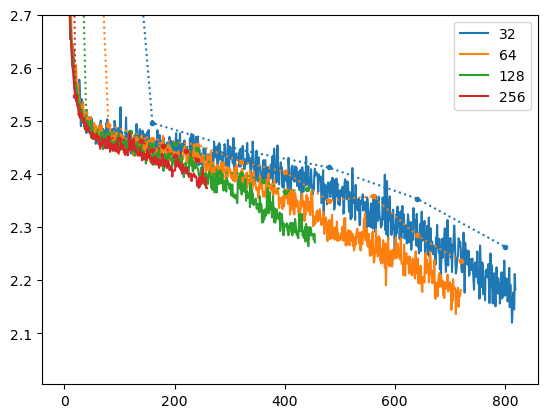

In [44]:
# this plot is outdated (from runs before dropout)
# but we just need the x axis here so no need to update it...

plot_performance(model32)
plot_performance(model64)
plot_performance(model128)
plot_performance(model256)
plt.ylim(None,2.7)
plt.legend(['32','64','128','256'])

Pick 64 because at 32 the compute is already inefficient.

In [26]:
# vary learning rate
config = {
    'n_layer':6,
    'n_model':256,
    'n_ff':1024,
    'n_head':8,
    'head_size':32, # fix head_size * n_head = n_model; also needs to be even for RoPE
    'n_context':256,
    'n_token':66, # come from data
    'RoPE':True,
    'dropout':0.1,
    'n_batch':64,
    'lr':1e-3,
    'weight_decay':0.1,
}

In [27]:
t_max=120
config['lr']=1e-3
model1e_3 = check_performance(config, t_max=t_max)
config['lr']=3e-3
model3e_3 = check_performance(config, t_max=t_max)
config['lr']=3e-4
model3e_4 = check_performance(config, t_max=t_max)

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


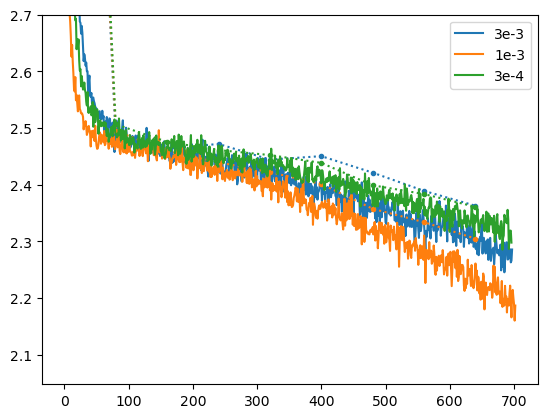

In [28]:
plot_performance(model3e_3)
plot_performance(model1e_3)
plot_performance(model3e_4)
plt.ylim(None,2.7)
plt.legend(['3e-3','1e-3','3e-4'])

Pick 1e-3. Maybe worth switching to 3e-4 at a later time?

In [29]:
# vary dropout
config = {
    'n_layer':6,
    'n_model':256,
    'n_ff':1024,
    'n_head':8,
    'head_size':32, # fix head_size * n_head = n_model; also needs to be even for RoPE
    'n_context':256,
    'n_token':66, # come from data
    'RoPE':True,
    'dropout':0.1,
    'n_batch':64,
    'lr':1e-3,
    'weight_decay':0.1,
}

In [30]:
t_max=120
model0d1 = model1e_3
config['dropout']=0.
model0d0 = check_performance(config, t_max=t_max)
config['dropout']=0.2
model0d2 = check_performance(config, t_max=t_max)
config['dropout']=0.3
model0d3 = check_performance(config, t_max=t_max)

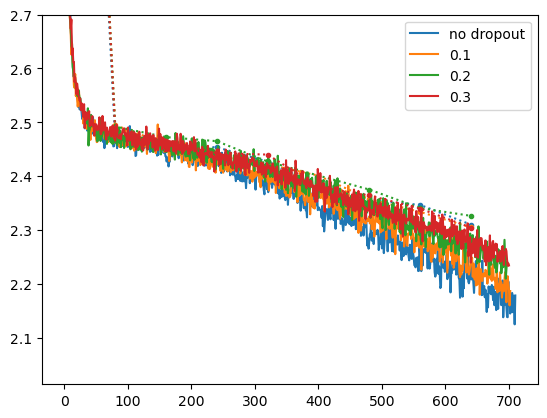

In [32]:
plot_performance(model0d0)
plot_performance(model0d1)
plot_performance(model0d2)
plot_performance(model0d3)
plt.ylim(None,2.7)
plt.legend(['no dropout','0.1','0.2','0.3'])

Any dropout does increase training loss... but in previous attempt I already saw that overfitting is very significant. Maybe just go for 0.1 here.

# Training

In [48]:
config = {
    'n_layer':6,
    'n_model':256,
    'n_ff':1024,
    'n_head':8,
    'head_size':32, # fix head_size * n_head = n_model; also needs to be even for RoPE
    'n_context':256,
    'n_token':66, # come from data
    'RoPE':True,
    'dropout':0.2, # higher dropout
    'n_batch':64,
    'lr':3e-4, # lower training rate
    'weight_decay':0.1,
}

In [49]:
# model setup
model = TransformerModel(config)
model.to(DEVICE)

# optimizer setup
optimizer = torch.optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['weight_decay'])
validation_interval = int(20 * 256/config['n_batch']) # validation evaluation ~ 10% training evaluation

# start loop
t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 0, train loss = 4.2858, val loss = 4.2995
epoch 80, train loss = 2.4908, val loss = 2.5013
epoch 160, train loss = 2.4595, val loss = 2.4675
epoch 240, train loss = 2.4521, val loss = 2.4672
epoch 320, train loss = 2.4398, val loss = 2.4618
epoch 400, train loss = 2.4112, val loss = 2.4356
epoch 480, train loss = 2.3938, val loss = 2.4014
epoch 560, train loss = 2.3682, val loss = 2.4054
epoch 640, train loss = 2.3447, val loss = 2.3725
epoch 720, train loss = 2.3315, val loss = 2.3633
epoch 800, train loss = 2.3092, val loss = 2.3527
epoch 880, train loss = 2.2978, val loss = 2.3301
epoch 960, train loss = 2.2668, val loss = 2.3408
took 170.26s


In [82]:
t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 9040, train loss = 1.2590, val loss = 1.4904
epoch 9120, train loss = 1.2516, val loss = 1.4560
epoch 9200, train loss = 1.2282, val loss = 1.5153
epoch 9280, train loss = 1.2411, val loss = 1.4619
epoch 9360, train loss = 1.2336, val loss = 1.4642
epoch 9440, train loss = 1.2513, val loss = 1.4697
epoch 9520, train loss = 1.2410, val loss = 1.4898
epoch 9600, train loss = 1.2445, val loss = 1.4743
epoch 9680, train loss = 1.2472, val loss = 1.4491
epoch 9760, train loss = 1.2490, val loss = 1.4901
epoch 9840, train loss = 1.2172, val loss = 1.4739
epoch 9920, train loss = 1.2206, val loss = 1.5046
took 179.28s


In [86]:
#torch.save(model.state_dict(), 'model.10000.pth')

(1.1112650394439698, 2.7)

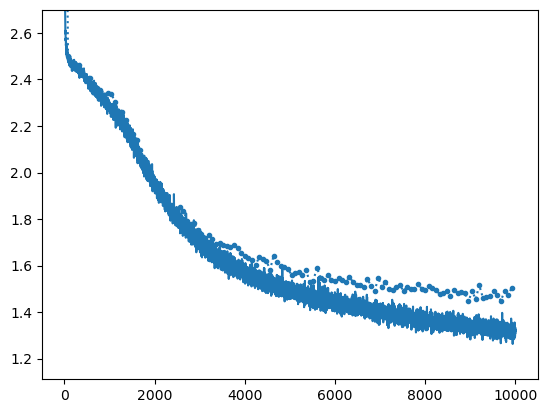

In [85]:
plot_performance(model)
plt.ylim(None,2.7)

In [84]:
_ = generate_from_model(model)

s smack
That at the parting all the church did echo:
And I seeing this came thence for very shame;
And after me, I know, the rout is coming.
Such a mad marriage never was before:
Hark, hark! I hear the minstrels play.

PETRUCHIO:
Gentlemen and friends, I this lie age.

KING HENRY V:
Somerely:
Lesst to Foold Signigure and this prouds,
Thou couldst pale of deep: he had moverheard
Halts fortuna fortunation: my leach, tread,
That see honwing, trhy the command spread my
It love, the Roman's night, nought unly,
And wereter my lord peace, whom nabels,
Behat got curstom gentlemally watery are.
I'll igoor lord, let enours, do nevouch, as I
This talk moisde. Some noble.
But, you this and callexing the safer shre
Did thousand earr'd me. Anon, the foot woeep comment.
Be


# Previous attempts of training

In [33]:
config = {
    'n_layer':6,
    'n_model':256,
    'n_ff':1024,
    'n_head':8,
    'head_size':32, # fix head_size * n_head = n_model; also needs to be even for RoPE
    'n_context':256,
    'n_token':66, # come from data
    'RoPE':True,
    'dropout':0.1,
    'n_batch':64,
    'lr':1e-3,
    'weight_decay':0.1,
}

In [34]:
# model setup
model = TransformerModel(config)
model.to(DEVICE)

# optimizer setup
optimizer = torch.optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['weight_decay'])
validation_interval = int(20 * 256/config['n_batch']) # validation evaluation ~ 10% training evaluation

# start loop
t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 0, train loss = 4.3108, val loss = 4.3144
epoch 80, train loss = 2.4694, val loss = 2.4757
epoch 160, train loss = 2.4439, val loss = 2.4661
epoch 240, train loss = 2.4307, val loss = 2.4707
epoch 320, train loss = 2.3984, val loss = 2.4300
epoch 400, train loss = 2.3473, val loss = 2.4019
epoch 480, train loss = 2.3322, val loss = 2.3712
epoch 560, train loss = 2.2662, val loss = 2.3580
epoch 640, train loss = 2.2415, val loss = 2.2971
epoch 720, train loss = 2.1962, val loss = 2.2704
epoch 800, train loss = 2.1251, val loss = 2.2014
epoch 880, train loss = 2.0536, val loss = 2.1036
epoch 960, train loss = 1.9242, val loss = 2.0131
took 170.41s


In [37]:
t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 1040, train loss = 1.8348, val loss = 1.9200
epoch 1120, train loss = 1.7785, val loss = 1.8826
epoch 1200, train loss = 1.6723, val loss = 1.7927
epoch 1280, train loss = 1.6372, val loss = 1.7697
epoch 1360, train loss = 1.6099, val loss = 1.7165
epoch 1440, train loss = 1.5436, val loss = 1.6916
epoch 1520, train loss = 1.5279, val loss = 1.6665
epoch 1600, train loss = 1.5058, val loss = 1.6363
epoch 1680, train loss = 1.4645, val loss = 1.6102
epoch 1760, train loss = 2.2316, val loss = 2.3056
epoch 1840, train loss = 1.6100, val loss = 1.7580
epoch 1920, train loss = 1.4915, val loss = 1.6243
took 170.10s


In [39]:
t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 2000, train loss = 1.4870, val loss = 1.6279
epoch 2080, train loss = 1.4306, val loss = 1.5900
epoch 2160, train loss = 1.4261, val loss = 1.5565
epoch 2240, train loss = 1.4064, val loss = 1.5511
epoch 2320, train loss = 1.3953, val loss = 1.5679
epoch 2400, train loss = 1.3941, val loss = 1.5597
epoch 2480, train loss = 1.3571, val loss = 1.5371
epoch 2560, train loss = 1.3713, val loss = 1.5179
epoch 2640, train loss = 1.3508, val loss = 1.5153
epoch 2720, train loss = 1.3513, val loss = 1.5284
epoch 2800, train loss = 1.3763, val loss = 1.5599
epoch 2880, train loss = 1.3321, val loss = 1.5151
epoch 2960, train loss = 1.3147, val loss = 1.4954
took 170.92s


In [44]:
# try a lower learning rate
for param_group in optimizer.param_groups:
    param_group['lr'] = 3e-4

t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 3040, train loss = 1.2808, val loss = 1.4611
epoch 3120, train loss = 1.2701, val loss = 1.4683
epoch 3200, train loss = 1.2635, val loss = 1.4765
epoch 3280, train loss = 1.2668, val loss = 1.4707
epoch 3360, train loss = 1.2552, val loss = 1.4771
epoch 3440, train loss = 1.2435, val loss = 1.4505
epoch 3520, train loss = 1.2649, val loss = 1.4654
epoch 3600, train loss = 1.2416, val loss = 1.4594
epoch 3680, train loss = 1.2363, val loss = 1.4803
epoch 3760, train loss = 1.2313, val loss = 1.4268
epoch 3840, train loss = 1.2369, val loss = 1.4616
epoch 3920, train loss = 1.2359, val loss = 1.4647
took 170.23s


In [46]:
#torch.save(model.state_dict(), 'model.4000.pth')

In [47]:
_ = generate_from_model(model)


I commanded the sleeves should be cut out and
sewed up again; and that I'll prove upon thee,
though thy little finger be armed in a thimble.

Tailor:
This is true that I say: an I had thee
in place where, thou shouldst know it.

GRUMIO:
I am for thee straight: I all thy have made thee,
unbrupt was end that down to their back thee wist glords.
I mine, plain, but I have wear no celll,
have mode a feel I'll heread be for thee: though
if Of this raw thou thy gostland, which he was thou
have have done'stered wrong-not conceit to bed
Than a the king's what wicke to it time, withach
To make many sworthin?

EXETON:
Come aptieous Margaret Cobunes. never comut? Rome was
On my deserns, well friend no his hollow.

DORSET:
Well, mighty friend; bereflioMJl
Which old he i


(1.0874538719654083, 2.7)

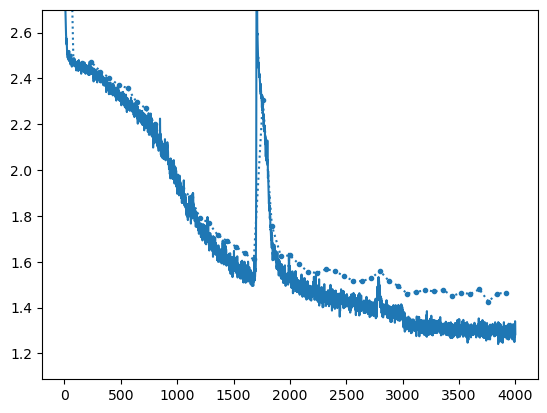

In [45]:
plot_performance(model)
plt.ylim(None,2.7)

# Previous attempts of training (before dropout)

In [52]:
config = {
    'n_layer':6,
    'n_model':256,
    'n_ff':1024,
    'n_head':8,
    'head_size':32, # fix head_size * n_head = n_model; also needs to be even for RoPE
    'n_context':256,
    'n_token':66, # come from data
    'RoPE':True,
    'n_batch':64,
    'lr':1e-3,
    'weight_decay':0.2,
}

In [57]:
# model setup
model = TransformerModel(config)
model.to(DEVICE)

# optimizer setup
optimizer = torch.optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['weight_decay'])
validation_interval = int(20 * 256/config['n_batch']) # validation evaluation ~ 10% training evaluation

# start loop
t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 0, train loss = 4.2994, val loss = 4.2814
epoch 80, train loss = 2.4710, val loss = 2.4766
epoch 160, train loss = 2.4482, val loss = 2.4729
epoch 240, train loss = 2.4168, val loss = 2.4537
epoch 320, train loss = 2.3971, val loss = 2.4339
epoch 400, train loss = 2.3477, val loss = 2.4136
epoch 480, train loss = 2.3206, val loss = 2.3693
epoch 560, train loss = 2.2830, val loss = 2.3616
epoch 640, train loss = 2.2424, val loss = 2.3272
epoch 720, train loss = 2.1943, val loss = 2.2625
epoch 800, train loss = 2.1223, val loss = 2.2004
epoch 880, train loss = 2.0623, val loss = 2.1317
epoch 960, train loss = 2.0187, val loss = 2.0920
took 167.82s


In [63]:
t_start = time.time()
for i in range(1000):
    # validation
    if model.current_epoch%validation_interval==0:
        tl, vl = validation(model, print_loss=True)
        model.diag_epochs.append(model.current_epoch)
        model.diag_train_loss.append(tl)
        model.diag_val_loss.append(vl)
    x, y = model_data.draw(config['n_batch'])
    optimizer.zero_grad()
    _, loss = model(x, y)
    loss.backward()
    optimizer.step()
    model.losses.append(loss.item())
    model.current_epoch += 1
t_now = time.time()
print(f"took {t_now-t_start:.2f}s")

epoch 2000, train loss = 1.3713, val loss = 1.5613
epoch 2080, train loss = 1.3405, val loss = 1.5958
epoch 2160, train loss = 1.3381, val loss = 1.5391
epoch 2240, train loss = 1.3180, val loss = 1.5545
epoch 2320, train loss = 1.7733, val loss = 1.9494
epoch 2400, train loss = 1.3039, val loss = 1.5560
epoch 2480, train loss = 1.3089, val loss = 1.5606
epoch 2560, train loss = 1.2782, val loss = 1.5520
epoch 2640, train loss = 1.2755, val loss = 1.5316
epoch 2720, train loss = 1.2499, val loss = 1.5163
epoch 2800, train loss = 1.2467, val loss = 1.5614
epoch 2880, train loss = 1.2513, val loss = 1.5623
epoch 2960, train loss = 1.2454, val loss = 1.5567
took 167.25s


In [65]:
#torch.save(model.state_dict(), 'model.3000.pth')

(1.0364717245101929, 2.7)

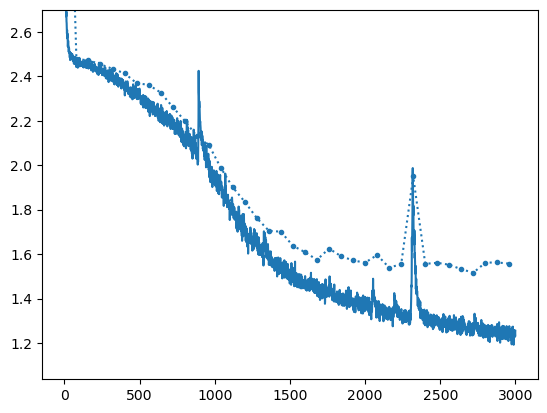

In [64]:
plot_performance(model)
plt.ylim(None,2.7)

Overfitting is still significant. Maybe we should try additional regularization using dropout?

In [69]:
_ = generate_from_model(model)

er:
may I be so bold to know the cause of your coming?

TRANIO:
Pardon me, sir, the boldness is mine own,
That, being a stranger in this city here,
Do make myself a suitor to your daughter,
Unto Bianca, fair and virtuous.
Nor is your firm resolve unknown to rough numbs:
I never speak, single is were so shall night,
O delse stumble to die.

BRUTUS:
Very ready it that way:
Is it not all know thee stilled equal Sicily.

Both Juliet, that let them great again; that hast
Thy thought of thy veil in for To Comford them
corn to pluck against hope thee weigh
I'll poish'd them. This lovinglinents
The good keep forces the father of ware droubs,
There season im'stilles would eyoung see
And did trown away the points on me:-long awder so
Theseiry being it our poor party,

